In [1]:
import sys
sys.path.append("..")

import pandas as pd

from torch.utils.data import DataLoader, Subset
from model_zoo import get_model
from dataset_zoo import VG_Relation, VG_Attribution

from transformers import ViltProcessor, ViltForImageAndTextRetrieval, GPT2LMHeadModel, GPT2Tokenizer

import clip
import torch
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import language_tool_python

In [2]:
# Please put your data root directory below. We'll download VG-Relation and VG-Attribution images here. 
# Will be a 1GB zip file (a subset of GQA).
root_dir="C:/Users/ewang/OneDrive/Desktop/Fall 2023/CompVLMs/vision-language-models-are-bows/data2" 


In [3]:
model, preprocess = get_model(model_name="openai-clip:ViT-B/32", device="cuda", root_dir=root_dir)

In [142]:
model, preprocess = get_model(model_name="blip-flickr-base", device="cuda", root_dir=root_dir)

load checkpoint from C:/Users/ewang/OneDrive/Desktop/Fall 2023/CompVLMs/vision-language-models-are-bows/data2\blip-flickr-base.pth
missing keys:
[]


In [21]:
model, preprocess = get_model(model_name="NegCLIP", device="cuda", root_dir=root_dir)

In [4]:
model, preprocess = get_model(model_name="vilt-b32-finetuned-coco", device="cuda", root_dir=root_dir)

In [4]:
# Load pre-trained model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Function to get the likelihood of a sequence of words
def get_sequence_likelihood(sentence):
    tokenize_input = tokenizer.encode(sentence, return_tensors="pt")
    loss = model(tokenize_input, labels=tokenize_input).loss
    return torch.exp(-loss).item()

In [6]:
@torch.no_grad()
def get_data(joint_loader):
    """Computes the scores for each image_option / caption_option pair in the joint loader.

    Args:
        joint_loader (DataLoader): batches have "image_options" and "caption_options" fields.
        "image_options" is a list of images, and "caption_options" is a list of captions.

    Returns:
        all_scores: A numpy array containing the scores of the shape NxKxL,
        where N is the number of test cases, K is the number of image options per the test case,
        and L is the number of caption options per the test case.
    """

    tqdm_loader = tqdm(joint_loader)
    # tqdm_loader.set_description("Computing retrieval scores")

    images = []
    captions = []


    for batch in tqdm_loader:


        for i_option in batch["image_options"]: # length 1
            images.append(i_option)
        for c_option in batch["caption_options"]: # length 2
            
            captions.append(c_option)

    return images, captions

In [7]:
@torch.no_grad()
def get_data(joint_loader):
    """Computes the scores for each image_option / caption_option pair in the joint loader.

    Args:
        joint_loader (DataLoader): batches have "image_options" and "caption_options" fields.
        "image_options" is a list of images, and "caption_options" is a list of captions.

    Returns:
        all_scores: A numpy array containing the scores of the shape NxKxL,
        where N is the number of test cases, K is the number of image options per the test case,
        and L is the number of caption options per the test case.
    """

    tqdm_loader = tqdm(joint_loader)
    # tqdm_loader.set_description("Computing retrieval scores")

    images = []
    captions = []


    for batch in tqdm_loader:


        for i_option in batch["image_options"]: # length 1
            images.append(i_option)
        for c_option in batch["caption_options"]: # length 2
            
            captions.append(c_option)

    return images, captions

In [8]:
@torch.no_grad()
def get_prob(joint_loader):

    # tqdm_loader.set_description("Computing retrieval scores")
    probs1 = torch.empty(len(joint_loader)*16)
    probs2 = torch.empty(len(joint_loader)*16)

    probs1.to("cuda")
    probs2.to("cuda")

    for k, batch in enumerate(joint_loader):
        incorrect = batch["caption_options"][0]
        correct = batch["caption_options"][1]

        for i in range(len(correct)):
            probs1[k*16+i] = get_sequence_likelihood(incorrect[i])
            probs2[k*16+i] = get_sequence_likelihood(correct[i])
            # probs1.append(get_sequence_likelihood(incorrect[i]))
            # probs2.append(get_sequence_likelihood(correct[i]))

    return probs1, probs2

In [53]:
get_sequence_likelihood("The people is to the left of the woman")

0.010229690931737423

In [54]:
# Get the VG-R dataset
vgr_dataset = VG_Relation(image_preprocess=preprocess, download=False, root_dir=root_dir)
vgr_loader = DataLoader(vgr_dataset, batch_size=16, shuffle=False)

subset_size = int(len(vgr_dataset) * 0.05)

subset_dataset = Subset(vgr_dataset, np.arange(subset_size))

vgr_loader = DataLoader(subset_dataset, batch_size=16, shuffle=False)

In [7]:
vgr_images, vgr_captions = get_data(vgr_loader)

100%|██████████| 449/449 [00:52<00:00,  8.62it/s]


In [55]:
probs1, probs2 = get_prob(vgr_loader)

probs1 = np.asarray(probs1)
probs2 = np.asarray(probs2)

TypeError: string indices must be integers, not 'str'

In [47]:
probs1 = np.asarray(probs1)
probs2 = np.asarray(probs2)

probs1.mean()

0.0030462517000716337

In [48]:
probs2.mean()

0.004132008640883522

In [51]:
sum(probs1 < probs2) / len(probs1)

0.7446068197633959

In [33]:
print(sum(probs1)/len(probs1))
print(sum(probs2)/len(probs2))

0.013111920882318944
0.014302681005045143


In [15]:


# Your tensor 'image_tensor' should be of shape (3, 224, 224) if it's an RGB image
# image_tensor = torch.randn(3, 224, 224)  # Example tensor, replace with your own

def show_tensor_image(image_tensor):
    # Check if the tensor is on GPU, and if so, move it back to CPU
    if image_tensor.is_cuda:
        image_tensor = image_tensor.cpu()

    # Convert to NumPy array after transposing the dimensions to (H x W x C)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')  # Hide the axes
    plt.show()

In [13]:
randomBatches = random.sample(range(0, len(vgr_images)), 10)
randomOptions = random.sample(range(0, 16), 2)

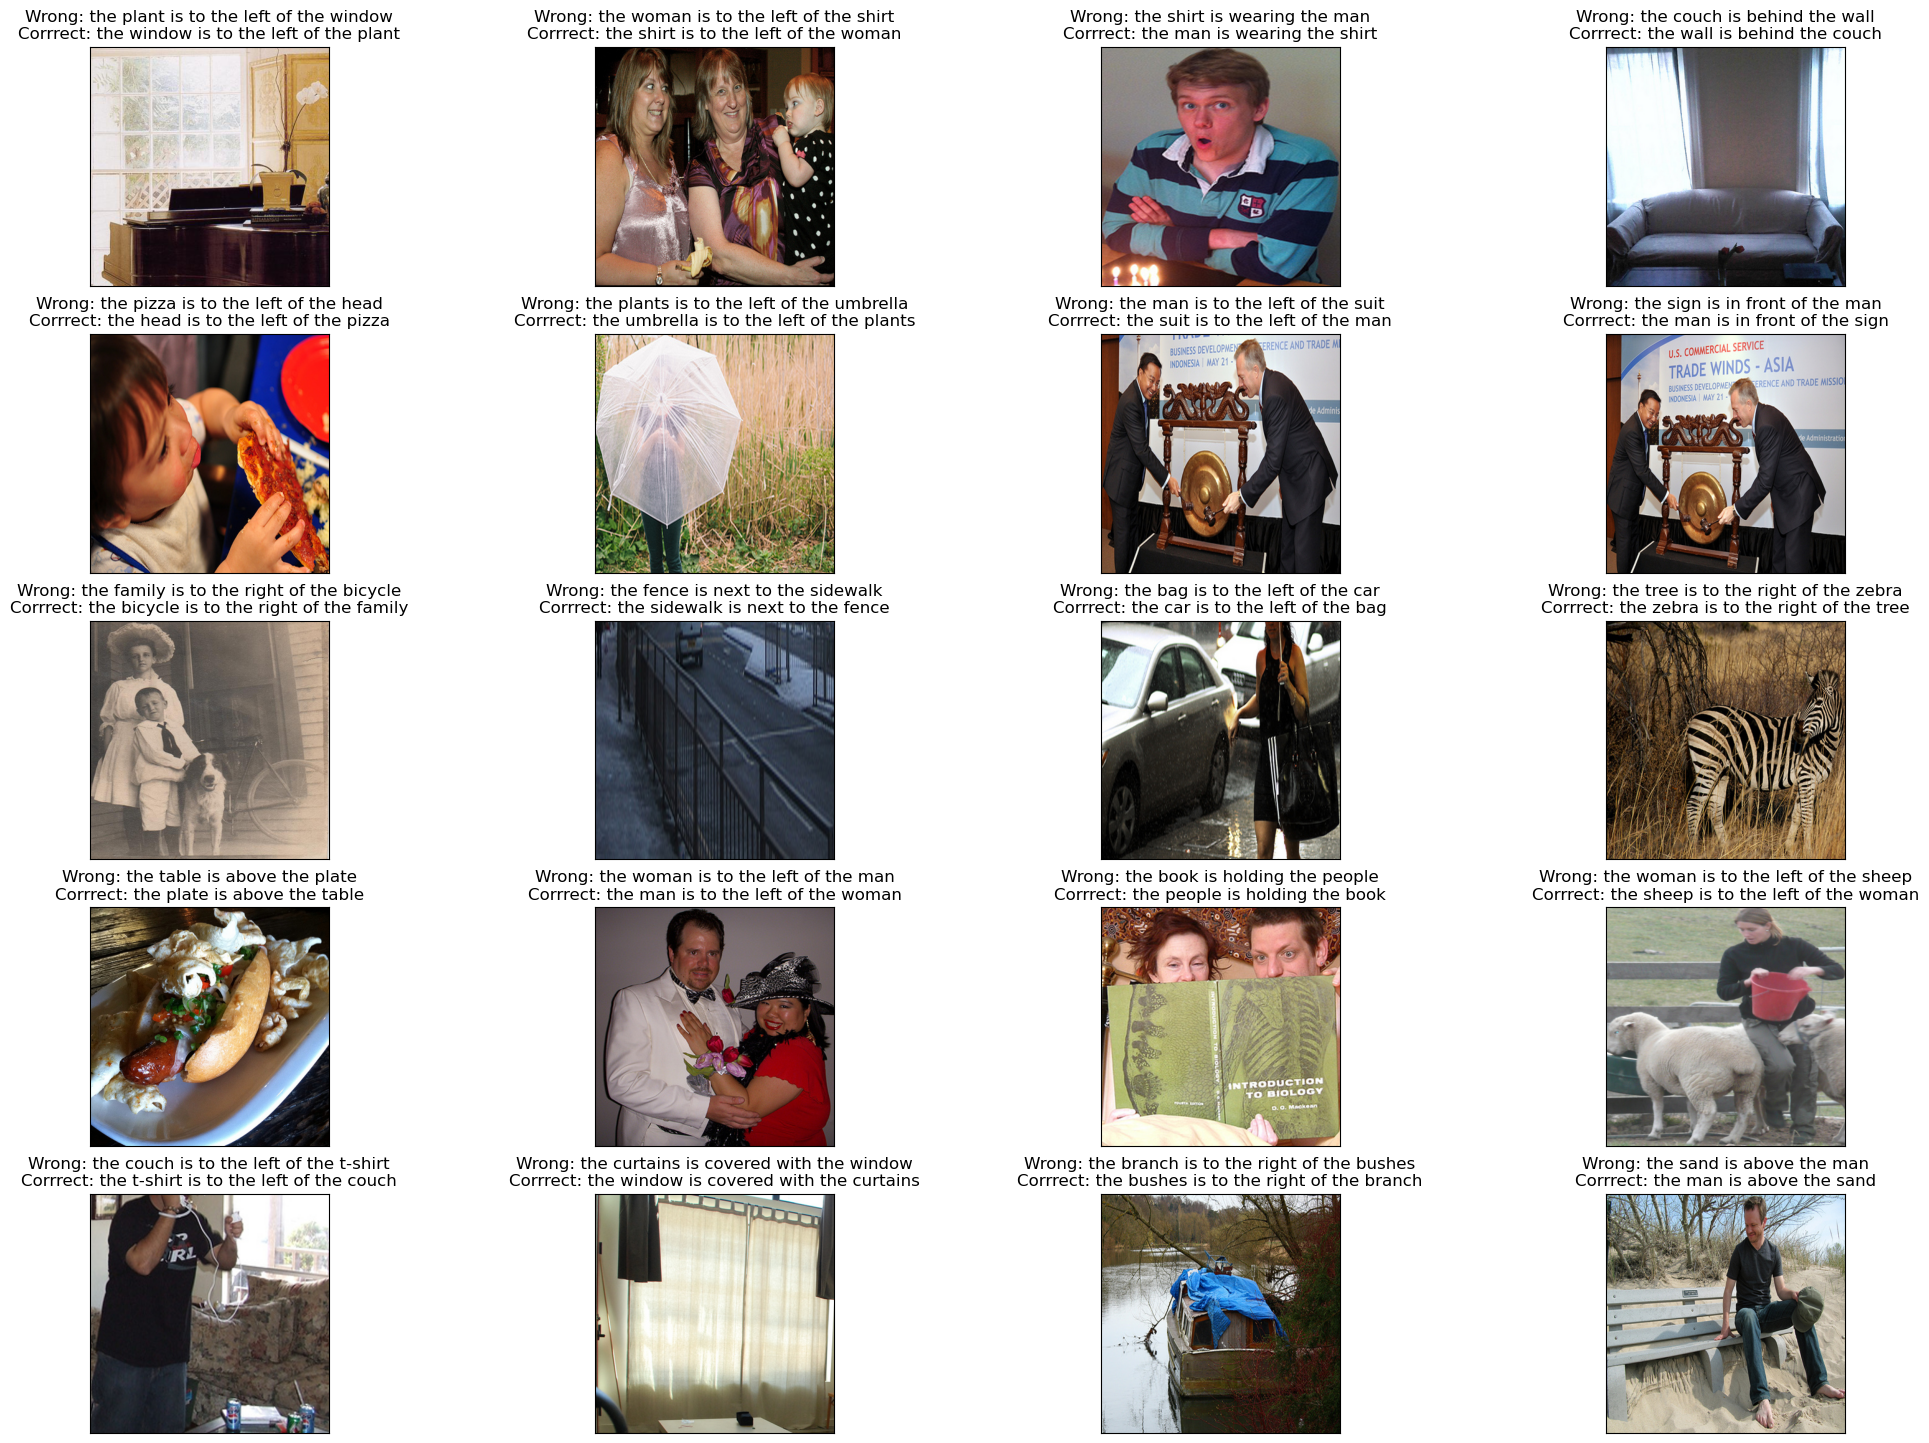

In [14]:
plt.figure(figsize=(25, 18))

for i in range(len(randomBatches)):
  for j in range(len(randomOptions)):
    image_tensor = vgr_images[randomBatches[i]][randomOptions[j]]
    if image_tensor.is_cuda:
      image_tensor = image_tensor.cpu()
    image_tensor = image_tensor.mul(255).byte()  
    image_numpy = image_tensor.permute(1,2,0).numpy()

    plt.subplot(5, 4, i*2+(j+1))
    plt.imshow(image_numpy.astype('uint8'))
    plt.title("Wrong: " + vgr_captions[randomBatches[i]*2][randomOptions[j]] +"\nCorrrect: " + vgr_captions[randomBatches[i]*2+1][randomOptions[j]], fontsize=12)
    plt.xticks([])
    plt.yticks([])

# plt.subplots_adjust(wspace=0)




In [35]:
# Get the VG-A dataset
vga_dataset = VG_Attribution(image_preprocess=preprocess, download=False, root_dir=root_dir)
vga_loader = DataLoader(vga_dataset, batch_size=16, shuffle=False)

subset_size = int(len(vga_dataset) * 0.05)

subset_dataset = Subset(vga_dataset, np.arange(subset_size))

vga_loader = DataLoader(subset_dataset, batch_size=16, shuffle=False)

In [36]:
probs1, probs2 = get_prob(vga_loader)
print(sum(probs1)/len(probs1))
print(sum(probs2)/len(probs2))

100%|██████████| 90/90 [05:08<00:00,  3.42s/it]

0.0030462517000716337
0.004132008640883522


In [11]:
vga_images, vga_captions = get_data(vga_loader)

100%|██████████| 539/539 [01:15<00:00,  7.11it/s]


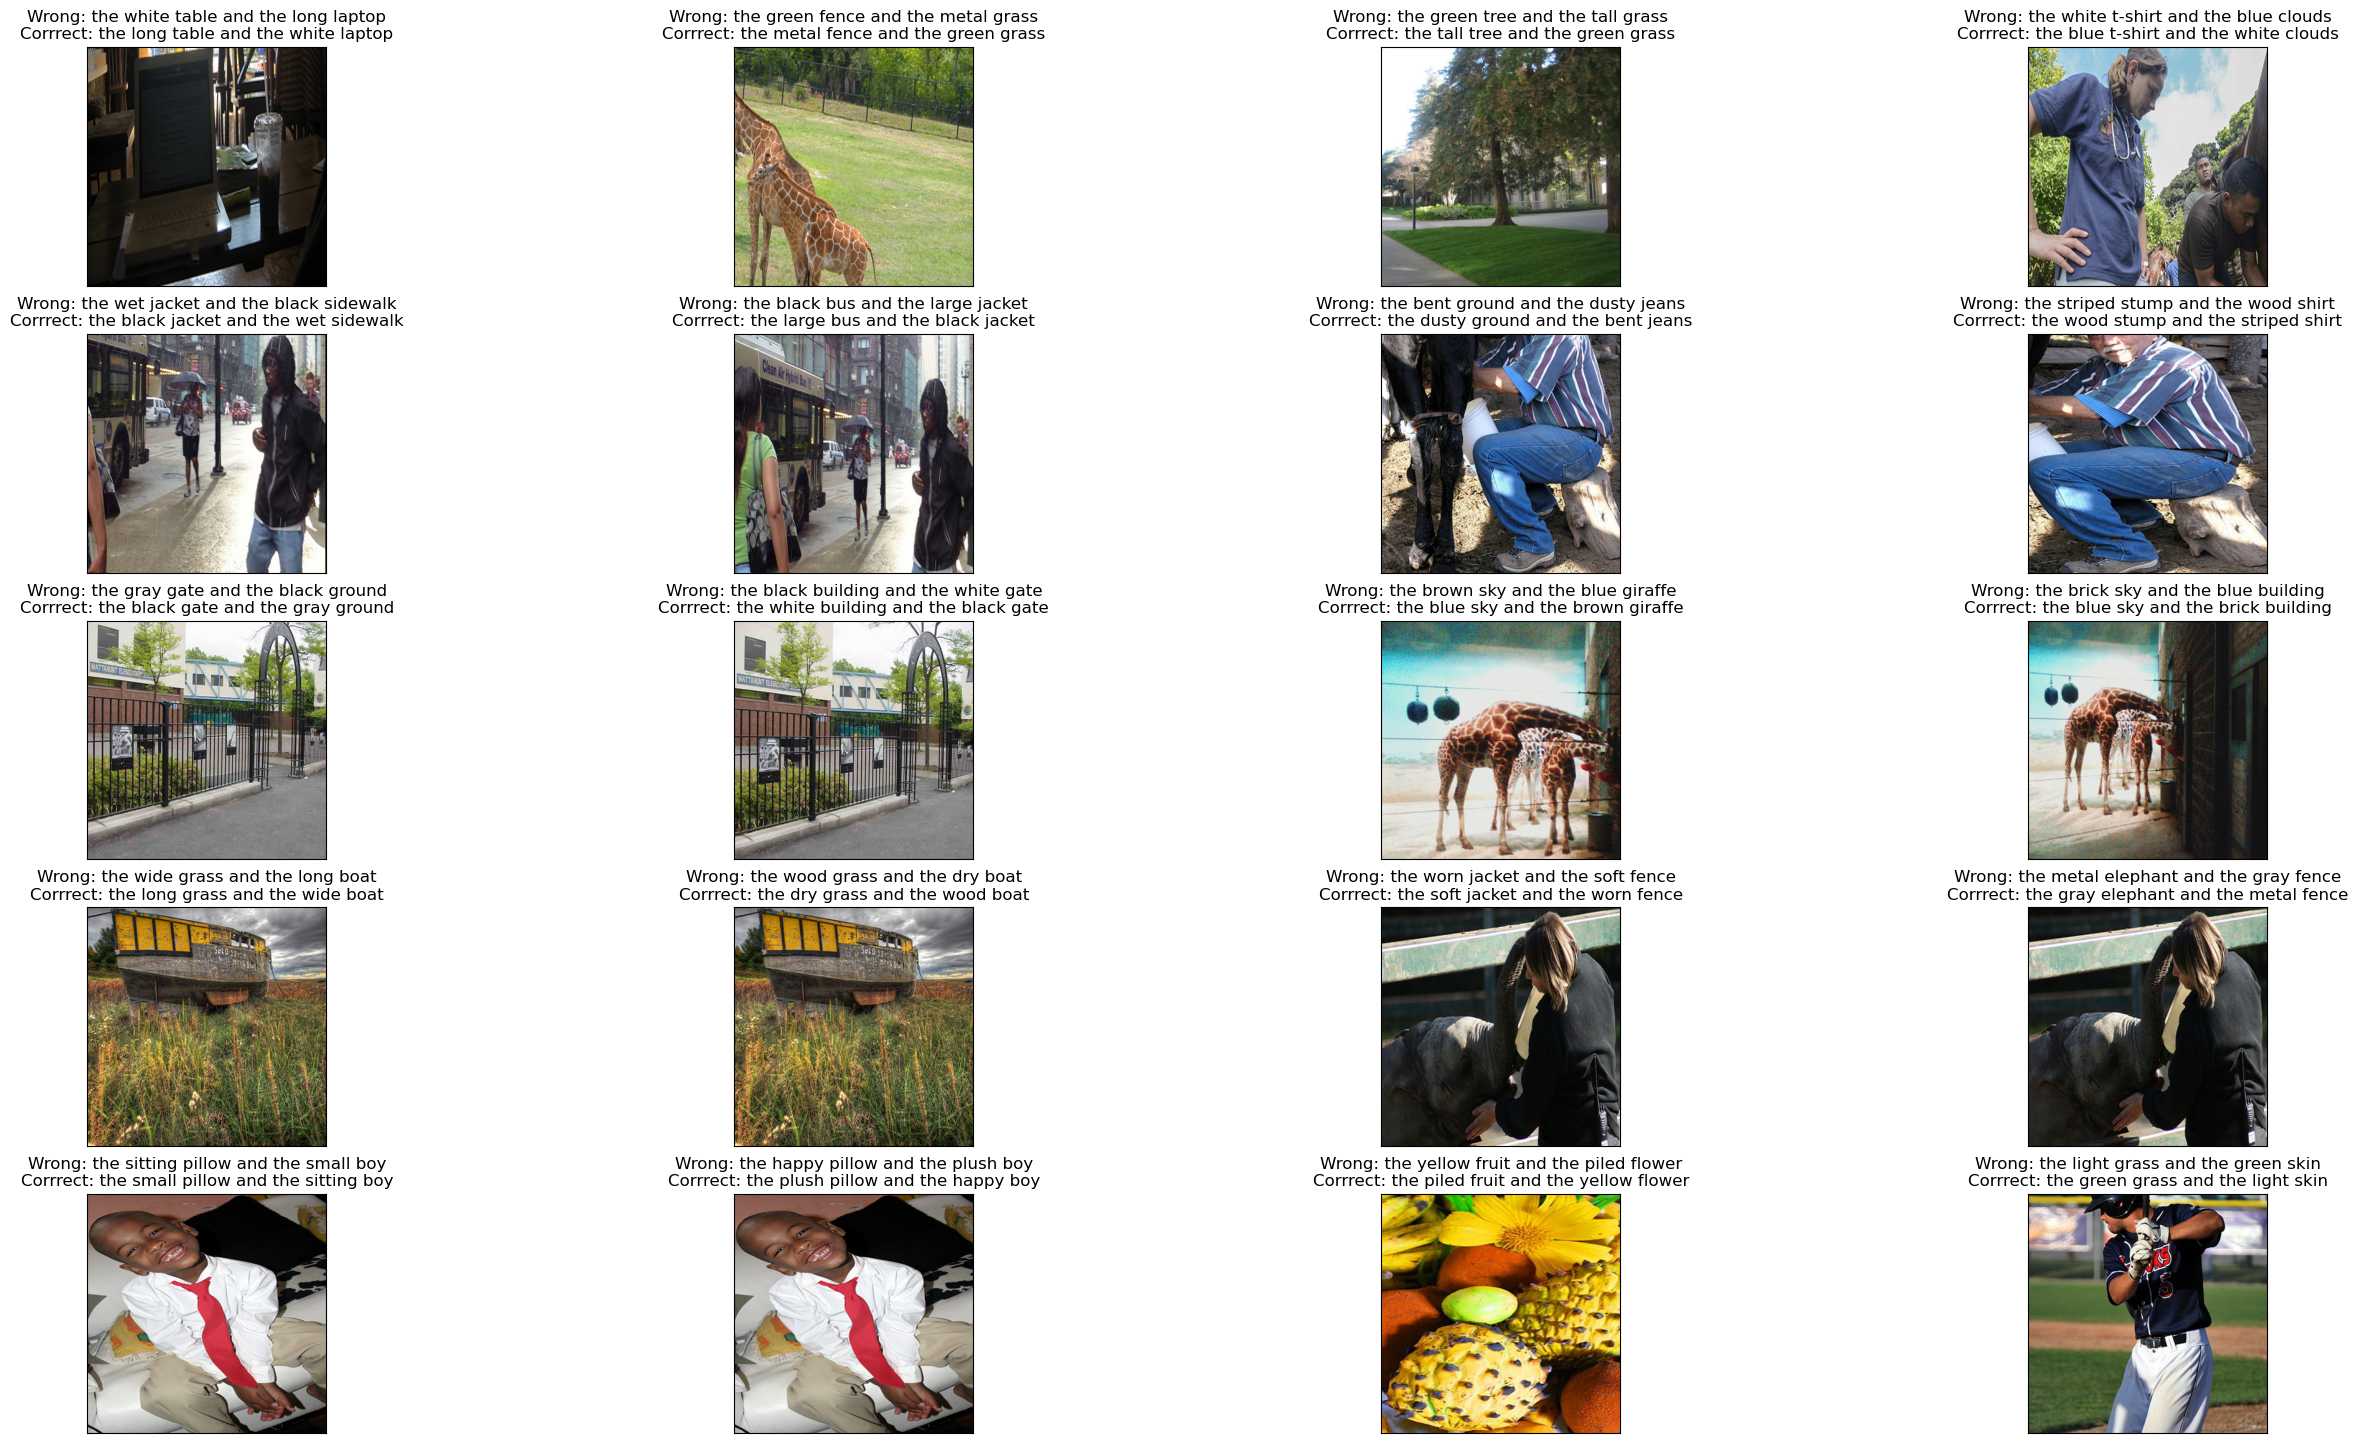

In [15]:

randomBatches = random.sample(range(0, len(vga_images)), 10)
randomOptions = random.sample(range(0, 16), 2)

plt.figure(figsize=(32, 18))

for i in range(len(randomBatches)):
  for j in range(len(randomOptions)):
    image_tensor = vga_images[randomBatches[i]][randomOptions[j]]
    if image_tensor.is_cuda:
      image_tensor = image_tensor.cpu()
    image_tensor = image_tensor.mul(255).byte()  
    image_numpy = image_tensor.permute(1,2,0).numpy()

    plt.subplot(5, 4, i*2+(j+1))
    plt.imshow(image_numpy.astype('uint8'))
    plt.title("Wrong: " + vga_captions[randomBatches[i]*2][randomOptions[j]] +"\nCorrrect: " + vga_captions[randomBatches[i]*2+1][randomOptions[j]], fontsize=12)
    plt.xticks([])
    plt.yticks([])
